## Image sample (DDPM - guided diffusion - Diffusion beats gans)

In [1]:
# from __future__ import print_function 
import argparse
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch as th
import torch.distributed as dist
import datetime
from collections import namedtuple

from guided_diffusion import logger, deca_dpm

from guided_diffusion.script_util import (
    NUM_CLASSES,
    model_and_diffusion_defaults,
    create_img_deca_and_diffusion,
    add_dict_to_argparser,
    args_to_dict,
    seed_all,
    diffusion_defaults,
)

In [2]:
def create_argparser(log_dir, img_model_path, deca_model_path, image_size, in_ch, out_ch, **kwargs):
    defaults = dict(
        clip_denoised=True,
        num_samples=1,
        batch_size=15,
        use_ddim=False,
        img_model_path=img_model_path,
        deca_model_path=deca_model_path,
        log_dir=log_dir,
        diffusion_step=1000,
        timestep_respacing=1000,
        image_size=image_size,
        in_image="raw",
        deca_cond=True,
    )

    defaults.update(model_and_diffusion_defaults(image_size=image_size, in_ch=in_ch, out_ch=out_ch))
    return namedtuple('GenericDict', defaults.keys())(**defaults)

def model_and_diffusion_defaults(image_size, in_ch, out_ch):
    """
    Defaults for image training.
    """
    res = dict(
        image_size=image_size,
        num_channels=128,
        in_channels=in_ch,
        out_channels=out_ch,
        num_res_blocks=2,
        num_heads=4,
        num_heads_upsample=-1,
        num_head_channels=-1,
        attention_resolutions="16,8",
        channel_mult="",
        dropout=0.0,
        class_cond=False,
        use_checkpoint=False,
        use_scale_shift_norm=True,
        resblock_updown=False,
        use_new_attention_order=False,
        deca_cond=True
    )
    res.update(diffusion_defaults())
    return res

In [3]:
# List model_logs
ct = "v7"
# sshfs_path = "/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/Mint/Work/Vision/Diffusion/mount/"
sshfs_path = "/home/mint/mount/model_logs_mount/"
model_logs_path = f"{sshfs_path}/{ct}/"
print(os.listdir(model_logs_path))

# args
log_dir = "DECA_128_raw"
# log_dir = "DECA_128"

step = "492500"
# step = "150000"
# ckpt = f"model{step}"
ckpt = f"ema_0.9999_{step}"
# model_logs_path = "/home2/mint/model_logs_mount/v8_model_logs/"
img_model_path = f"{model_logs_path}/{log_dir}/img_{ckpt}.pt"
deca_model_path = f"{model_logs_path}/{log_dir}/DECA_{ckpt}.pt"

image_size=128
in_ch = 3
out_ch = 3
args = create_argparser(log_dir=log_dir, img_model_path=img_model_path, deca_model_path=deca_model_path, image_size=image_size, in_ch=in_ch, out_ch=out_ch)

# Check model_logs
if not os.path.isdir(os.path.join(model_logs_path, args.log_dir)):
    print("No logs folder")
    raise FileNotFoundError
else: 
    if not os.path.isdir(os.path.join(model_logs_path, args.log_dir, "samples")):
        os.makedirs(os.path.join(model_logs_path, args.log_dir, "samples"))


# dist_util.setup_dist()
# logger.configure()

if args.in_image in ['raw', 'raw+uvdn']:
    model_and_diffusion = model_and_diffusion_defaults(image_size=image_size, in_ch=in_ch, out_ch=out_ch)
    print("creating {} model and diffusion...".format(args.in_image))
else:
    raise NotImplementedError


# for k, v in model_and_diffusion.items():
    # print(k, v)

img_model, deca_model, diffusion = create_img_deca_and_diffusion(
    **args_to_dict(args, model_and_diffusion.keys())
)


img_model.load_state_dict(
    th.load(args.img_model_path, map_location="cpu")
)

deca_model.load_state_dict(
    th.load(args.deca_model_path, map_location="cpu")
)

img_model.to('cuda')
deca_model.to('cuda')
img_model.eval()
deca_model.eval()



['flower_1k_hsv_100k', 'flower_1k_rbg', 'flower_1k_hls_100k', 'DECA_128_raw', 'flower_1k_hsv', 'flower_1k_rbg_100k', 'flower_1k_hls', 'flower_1k_ycrcb_100k', 'flower_1k_ycrcb']
creating raw model and diffusion...


DECADenseCond(
  (activation): LeakyReLU(negative_slope=0.01)
  (emb_layers): Sequential(
    (0): SiLU()
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (time_embed): Sequential(
    (0): Linear(in_features=128, out_features=512, bias=True)
    (1): SiLU()
    (2): Linear(in_features=512, out_features=512, bias=True)
  )
  (input_mlp): ModuleList(
    (0): Linear(in_features=159, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=512, bias=True)
  )
  (mid_mlp): Sequential(
    (0): Linear(in_features=33280, out_features=512, bias=True)
  )
  (output_mlp): ModuleList(
    (0): Linear(in_features=512, out_features=512, bias=True)
    (1): Linear(in_features=512, out_features=159, bias=True)
  )
)

In [4]:
def decolor(s, out_c='rgb'):
    if out_c in ['rgb', 'rbg', 'brg', 'bgr', 'grb', 'gbr']:
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'luv':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c == 'ycrcb':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)
    elif out_c in ['hsv', 'hls']:
        h = (s[..., [0]] + 1) * 90.0 
        l_s = (s[..., [1]] + 1) * 127.5
        v = (s[..., [2]] + 1) * 127.5
        s_ = th.cat((h, l_s, v), axis=2).clamp(0, 255).to(th.uint8)
    elif out_c == 'sepia':
        s_ = ((s + 1) * 127.5).clamp(0, 255).to(th.uint8)

    else: raise NotImplementedError

    return s_

def plot_sample(img, **kwargs):
    columns = 6
    rows = 10
    fig = plt.figure(figsize=(20, 20), dpi=100)
    img = img.permute(0, 2, 3, 1) # BxHxWxC
    pt = 0
    for i in range(0, img.shape[0]):
        s_ = decolor(s=img[i], out_c='rgb')
        s_ = s_.detach().cpu().numpy()
        fig.add_subplot(rows, columns, pt+1)
        plt.imshow(s_)
        pt += 1

        if kwargs is not None:
            # Plot other images
            for k in kwargs:
                fig.add_subplot(rows, columns, pt+1)
                s_ = decolor(s=kwargs[k][i].permute(1, 2, 0), out_c='rgb')
                s_ = s_.detach().cpu().numpy()
                plt.imshow(s_)
                pt += 1
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.65, 
                        top=0.9, 
                        wspace=0.1, 
                        hspace=0.2)
    plt.show()
        

  0%|          | 0/1000 [00:00<?, ?it/s]

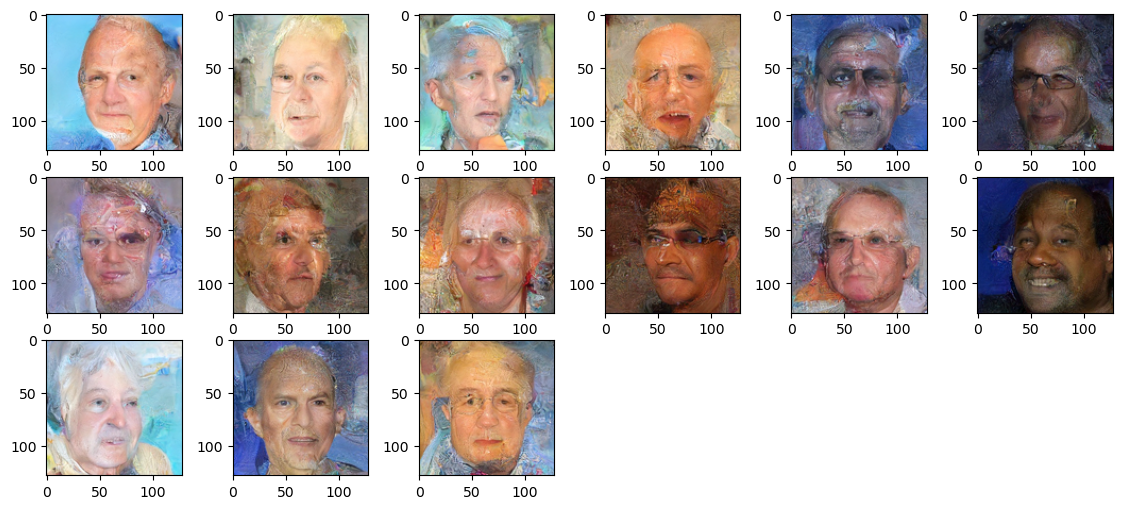

In [5]:
import pytorch_lightning as pl
class PLInference(pl.LightningModule):
    def __init__(self, img_model, deca_model, sample_fn):
        super(PLInference, self).__init__()
        self.img_model=img_model
        self.deca_model=deca_model
        self.sample_fn = sample_fn
        self.deca_dpm = deca_dpm.Diffusion_DECA(img_model=self.img_model, deca_model=self.deca_model, diffusion=diffusion, progress=True)

    def forward(self):
        seed_all(33)
        if self.sample_fn == 'p_sample_loop':
            img_output, deca_output = self.deca_dpm.p_sample_loop(
                                        shape_dict={'img':(args.batch_size, in_ch, args.image_size, args.image_size),
                                                    'deca':(args.batch_size, 159)})

        return {"img_output":img_output, "deca_output":deca_output}

pl_inference = PLInference(img_model=img_model, deca_model=deca_model, sample_fn='p_sample_loop')
sample = pl_inference()
B, C, _, _ = sample["img_output"].shape
if C == 6:
    plot_sample(sample["img_output"][:, :3, ...], uvdn=sample["img_output"][:, 3:, ...])
else :
    plot_sample(sample["img_output"][:, :3, ...])

In [6]:
# import pytorch_lightning as pl
# class PLInference(pl.LightningModule):
#     def __init__(self, img_model, deca_model, sample_fn):
#         super(PLInference, self).__init__()
#         self.img_model=img_model
#         self.deca_model=deca_model
#         self.sample_fn = sample_fn

#     def forward(self):
#         seed_all(33)
#         sample = self.sample_fn(
#             model=self.img_model,
#             shape=(args.batch_size, in_ch, args.image_size, args.image_size),
#             clip_denoised=args.clip_denoised,
#         )
#         return sample

# pl_inference = PLInference(img_model=img_model, deca_model=deca_model, sample_fn=diffusion.p_sample_loop)
# sample = pl_inference()
# plot(sample)

creating the FLAME Decoder


  0%|          | 0/15 [00:00<?, ?it/s]

/home/mint/miniconda3/envs/3dr_conda/lib/python3.8/site-packages/pytorch3d/io/obj_io.py:457: UserWarning: Mtl file does not exist: /home/mint/guided-diffusion/model_3d/FLAME/data/template.mtl
  warnings.warn(f"Mtl file does not exist: {f}")


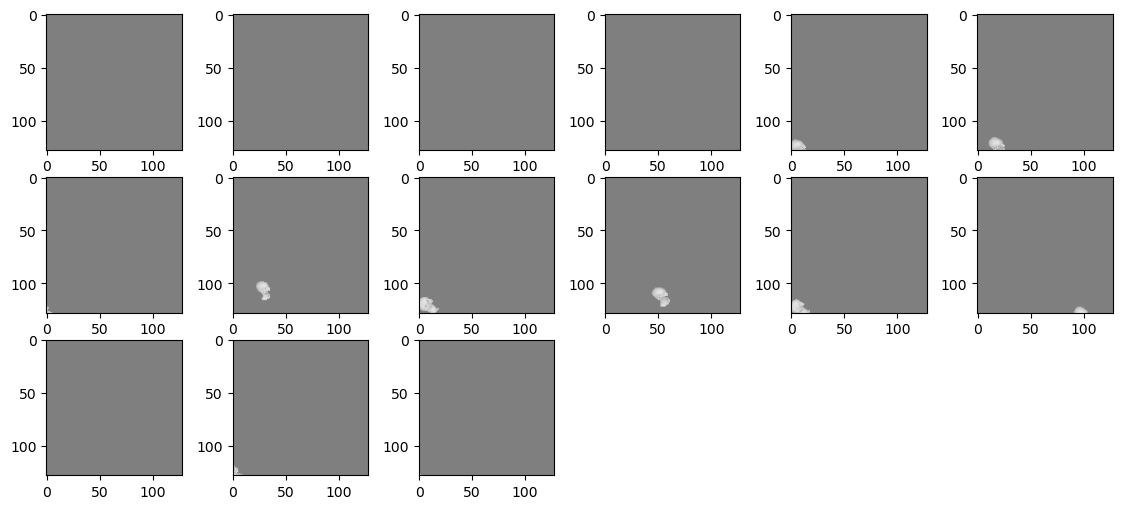

In [7]:
from ast import Expression, arg, parse
from pickle import PickleError
import argparse
import numpy as np
import pandas as pd
import torch as th
import torch.nn.functional as F
import glob, os
import PIL
import matplotlib.pyplot as plt
from model_3d.FLAME import FLAME
from model_3d.FLAME.config import cfg as flame_cfg
from collections import defaultdict
from model_3d.FLAME.utils.renderer import SRenderY
import model_3d.FLAME.utils.util as util
import model_3d.FLAME.utils.detectors as detectors
from skimage.io import imread, imsave
from skimage.transform import estimate_transform, warp, resize, rescale


def params_to_model(shape, exp, pose, cam, i, uvdn=None):
    verts, landmarks2d, landmarks3d = flame(shape_params=shape, 
            expression_params=exp, 
            pose_params=pose)

    renderer = SRenderY(image_size=args.image_size, obj_filename=flame_cfg.model.topology_path, uv_size=flame_cfg.model.uv_size).cuda()

    ## projection
    landmarks2d = util.batch_orth_proj(landmarks2d, cam)[:,:,:2]; landmarks2d[:,:,1:] = -landmarks2d[:,:,1:]#; landmarks2d = landmarks2d*self.image_size/2 + self.image_size/2
    landmarks3d = util.batch_orth_proj(landmarks3d, cam); landmarks3d[:,:,1:] = -landmarks3d[:,:,1:] #; landmarks3d = landmarks3d*self.image_size/2 + self.image_size/2
    trans_verts = util.batch_orth_proj(verts, cam); trans_verts[:,:,1:] = -trans_verts[:,:,1:]

    ## rendering
    shape_images = renderer.render_shape(verts, trans_verts)

    opdict = {'verts' : verts,}

    save_obj(renderer=renderer, filename=(f'./rendered_obj/{i}.obj'), opdict=opdict)
    # img_uvdn = th.unsqueeze(th.tensor(params['uv_detail_normals']).permute((2, 0, 1)), dim=0).cuda().to(flame.dtype)

    # detail_normal_images = F.grid_sample(img_uvdn, ops['grid'], align_corners=False)*ops['alpha_images']
    # shape_detail_images = renderer.render_shape(verts, trans_verts, detail_normal_images=detail_normal_images)

#     plt.imshow(np.concatenate((shape_images[0].detach().cpu().numpy().transpose([1, 2, 0]), 
#             ops['images'][0].detach().cpu().numpy().transpose([1, 2, 0]),
#             shape_detail_images[0].detach().cpu().numpy().transpose([1, 2, 0])
#             ), axis=1))
#     plt.show()
    return {"shape_images":shape_images}

def save_obj(renderer, filename, opdict):
    '''
    vertices: [nv, 3], tensor
    texture: [3, h, w], tensor
    '''
    i = 0
    vertices = opdict['verts'][i].cpu().numpy()
    faces = renderer.faces[0].cpu().numpy()
    colors = np.ones(shape=vertices.shape) * 127.5

    # save coarse mesh, with texture and normal map
    # normal_map = util.tensor2image(opdict['uv_detail_normals'][i]*0.5 + 0.5)
    util.write_obj(filename, vertices, faces, colors=colors)


flame = FLAME.FLAME(flame_cfg.model).cuda()

img_ = []
from tqdm.auto import tqdm
for i in tqdm(range(sample['deca_output'].shape[0])):
    deca_params = sample['deca_output'][i].float()
    shape = deca_params[None, :100]
    pose = deca_params[None, 100:106]
    exp = deca_params[None, 106:156]
    cam = deca_params[None, 156:]
    # print(shape.shape, type(shape), shape.device, shape.dtype)
    # print(pose.shape, type(pose), pose.device, pose.dtype)
    # print(exp.shape, type(exp), exp.device, exp.dtype)
    # print(cam.shape, type(cam), cam.device, cam.dtype)
    img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=i)
    img_.append(img["shape_images"])

plot_sample(th.cat(img_, dim=0))




# Analysis of Face params

In [8]:
# Test params_to_model fn
def read_params(path):
    params = pd.read_csv(path, header=None, sep=" ", index_col=False, lineterminator='\n')
    params.rename(columns={0:'img_name'}, inplace=True)
    params = params.set_index('img_name').T.to_dict('list')
    return params

def swap_key(params):
    params_s = defaultdict(dict)
    for params_name, v in params.items():
        for img_name, params_value in v.items():
            params_s[img_name][params_name] = np.array(params_value).astype(np.float64)

    return params_s


params_key = ['shape', 'pose', 'exp', 'cam']
# anno_path = glob.glob(f'/home/mint/mnt_tl_puntawat-ms-7c37/home/puntawat/mnt/sda2/anno/ffhq_256_with_anno/params/*.txt')
anno_path = glob.glob(f'/data/mint/ffhq_256_with_anno/params/*.txt')
params = {}
for k in params_key:
    for p in anno_path:
        # Params
        if k in p:
            print(f'Key=> {k} : Filename=>{p}')
            params[k] = read_params(path=p)

params_s = swap_key(params)

img_dataset_path = '/data/mint/ffhq_256_with_anno/ffhq_256/train/'

Key=> shape : Filename=>/data/mint/ffhq_256_with_anno/params/ffhq-train-shape-anno.txt
Key=> pose : Filename=>/data/mint/ffhq_256_with_anno/params/ffhq-train-pose-anno.txt
Key=> exp : Filename=>/data/mint/ffhq_256_with_anno/params/ffhq-train-exp-anno.txt
Key=> cam : Filename=>/data/mint/ffhq_256_with_anno/params/ffhq-train-cam-anno.txt


torch.Size([10, 3, 256, 256]) torch.Size([10, 3, 128, 128])


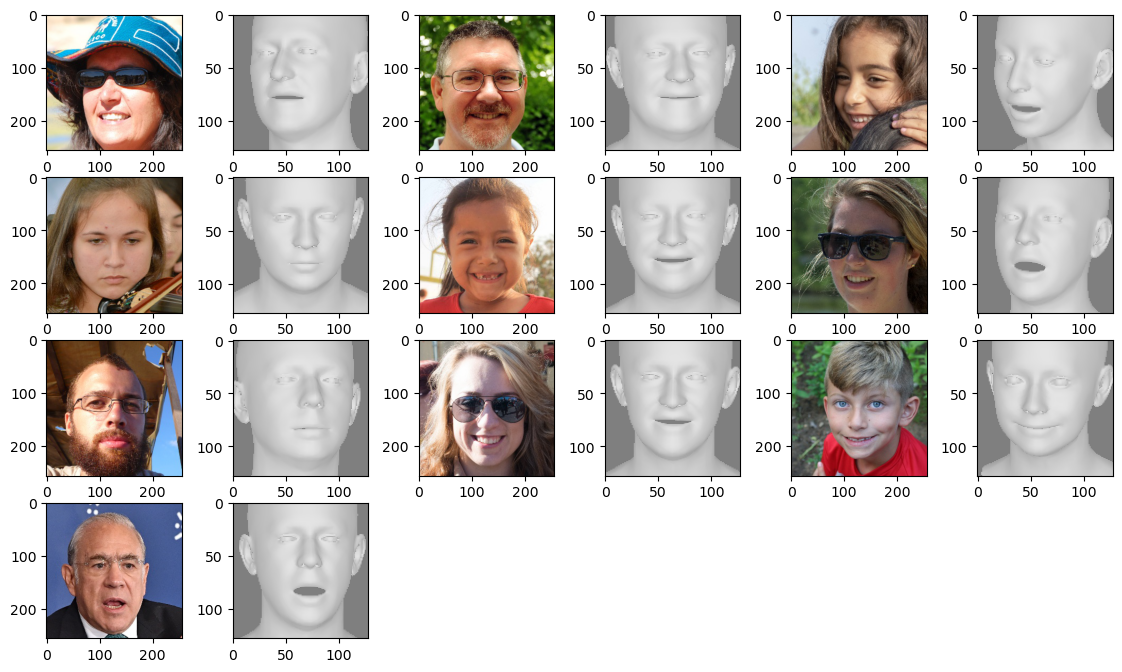

In [9]:
img_name_list = [str(n) + '.jpg' for n in list(np.random.randint(0, 60000, 10))]

render_img_list = []
src_img_list = []
img_list = []
for img_name in img_name_list:
    shape = th.tensor(params_s[img_name]['shape'][None, :]).float().cuda()
    pose = th.tensor(params_s[img_name]['pose'][None, :]).float().cuda()
    exp = th.tensor(params_s[img_name]['exp'][None, :]).float().cuda()
    cam = th.tensor(params_s[img_name]['cam'][None, :]).float().cuda()
    # print(cam)
    # assert False

    src_img = PIL.Image.open(img_dataset_path + img_name)
    src_img = (th.tensor(np.transpose(src_img, (2, 0, 1)))[None, :] / 127.5) - 1
    src_img_list.append(src_img)

    render_img = params_to_model(shape=shape, exp=exp, pose=pose, cam=cam, i=img_name)
    render_img_list.append(render_img["shape_images"])

src_img = th.cat(src_img_list, dim=0)
render_img = th.cat(render_img_list, dim=0)
print(src_img.shape, render_img.shape)
plot_sample(img=src_img, render_img=render_img)

In [10]:
print(sample["deca_output"].shape)
sample_params = {'shape':[], 'pose':[], 'exp':[], 'cam':[]}
for i in range(sample["deca_output"].shape[0]):
    deca_params = sample["deca_output"][i]
    shape = deca_params[None, :100].cpu().numpy()
    pose = deca_params[None, 100:106].cpu().numpy()
    exp = deca_params[None, 106:156].cpu().numpy()
    cam = deca_params[None, 156:].cpu().numpy()
    sample_params['shape'].append(shape)
    sample_params['pose'].append(pose)
    sample_params['exp'].append(exp)
    sample_params['cam'].append(cam)

for k in sample_params.keys():
    sample_params[k] = np.concatenate(sample_params[k], axis=0)


torch.Size([15, 159])


[#] Across all params&images
Train set : shape-params range : min=-3.4134045, max=2.4507303
Train set : shape-params range : mean=-0.007708137703523697, std=0.23000433978954066
[#] Across all images
Sampling set : shape-params range : min=[-1.         -0.00167429  0.57704301 -1.         -1.         -1.
 -1.          0.83881295  0.81091154 -1.         -0.73334216  0.77538278
 -0.9451474  -1.          0.91050102  0.36505232 -1.         -1.
 -1.         -0.27959548 -1.         -1.          0.42470116  0.18731612
 -1.         -1.         -0.99528721 -1.         -1.         -1.
 -0.88331316 -1.          0.88297066  0.39166789 -1.          0.99713864
 -1.          0.18039843 -0.96917085 -1.          0.17692649 -1.
 -1.         -1.         -1.         -1.          0.84618589 -0.77650722
 -1.         -1.         -1.         -1.          0.83104558 -1.
 -1.         -1.         -1.         -1.         -0.6896714   0.92331998
  0.89583363 -1.         -1.          0.8034501  -1.         -1.
  0.28

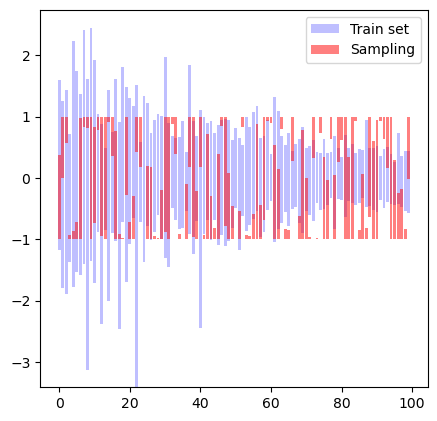

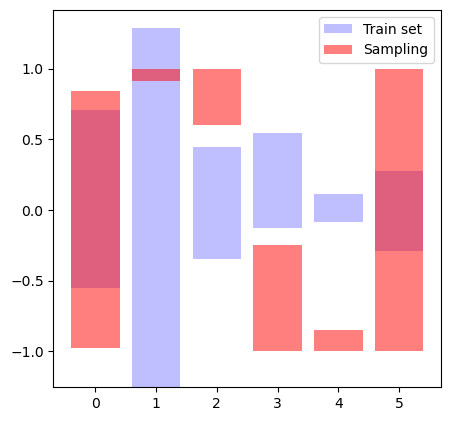

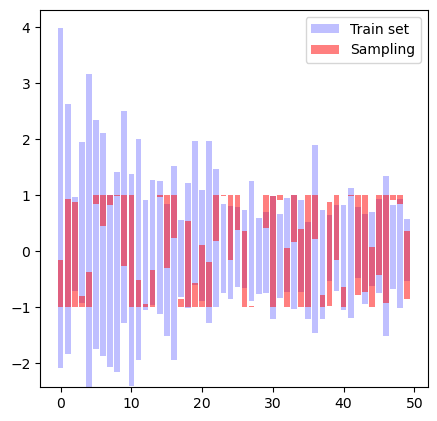

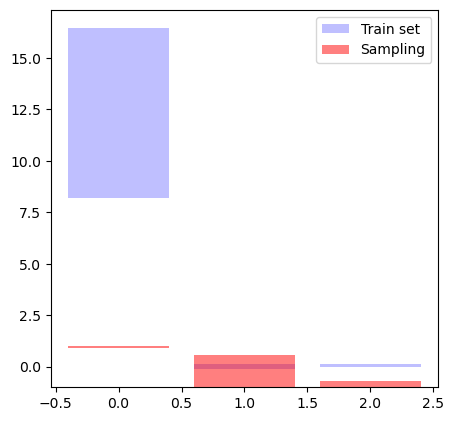

In [11]:
def simple_analyse(params, key, sample_params=None):
    '''
    :params: tensor in shape BxD
    '''
    print("[#] Across all params&images")
    print(f"Train set : {key}-params range : min={np.min(params)}, max={np.max(params)}")
    print(f"Train set : {key}-params range : mean={np.mean(params)}, std={np.std(params)}")
    print("[#] Across all images")
    # print(f"{key}-params range : min={np.min(params, axis=0)}, max={np.max(params, axis=0)}")
    # print(f"{key}-params range : mean={np.mean(params, axis=0)}, std={np.std(params, axis=0)}")
    fig = plt.figure(figsize=(5, 5), dpi=100)
    # plt.bar(np.arange(params.shape[-1]), np.min(params, axis=0), label=f"Train set : minimum of {key}", color=(0, 0, 1, 0.8))
    # plt.bar(np.arange(params.shape[-1]), np.max(params, axis=0), label=f"Train set : maximum of {key}", color=(0, 0, 1, 0.8))
    plt.bar(x=np.arange(params.shape[-1]), height=np.max(params, axis=0)-np.min(params, axis=0), bottom=np.min(params, axis=0), color=(0, 0, 1, 0.25), label="Train set")
    # import plotly.graph_objects as go
    # fig = go.Figure()
    # fig.add_trace(go.Bar(x=np.arange(params.shape[-1]), y=np.max(params, axis=0)-np.min(params, axis=0), 
    #                     base=np.min(params, axis=0), marker_color='red', width=0.5, barmode='stack'))


    if sample is not None:
        # fig.add_trace(go.Bar(x=np.arange(sample_params.shape[-1]), y=np.max(sample_params, axis=0)-np.min(sample_params, axis=0), 
        #                     base=np.min(sample_params, axis=0), marker_color='blue', width=0.5))
        print(f"Sampling set : {key}-params range : min={np.min(sample_params, axis=0)}, max={np.max(sample_params, axis=0)}")
        plt.bar(x=np.arange(sample_params.shape[-1]), height=np.max(sample_params, axis=0)-np.min(sample_params, axis=0), bottom=np.min(sample_params, axis=0), color=(1, 0, 0, 0.5), label="Sampling")
    #     print(f"Sampling set : {key}-params range : mean={np.mean(sample_params)}, std={np.std(sample_params)}")
    #     plt.bar(np.arange(sample_params.shape[-1]), np.min(sample_params, axis=0), label=f"Sampling : minimum of {key}", color=(1, 0, 0, 0.2))
    #     plt.bar(np.arange(sample_params.shape[-1]), np.max(sample_params, axis=0), label=f"Sampling : maximum of {key}", color=(1, 0, 0, 0.2))

    plt.legend()
    fig.show()

import plotly.figure_factory as ff

def dist_analyse(params, key, sample_params=None):
    group_labels = [f'comp-{i}' for i in range(params.shape[-1])]
    hist_data_params = [params[:, i] for i in range(params.shape[-1])]
    fig = ff.create_distplot(hist_data_params, group_labels, show_rug=False)
    fig.write_html(f"./{key}-dist.html")


params_list = ['shape', 'pose', 'exp', 'cam']
# params_list = ['cam']
for each_p in params_list:
    p = np.concatenate([params_s[k][each_p][None, :] for k in params_s.keys()], axis=0)
    simple_analyse(params=p, key=each_p, sample_params=sample_params[each_p])
    # dist_analyse(params=p, key=each_p, sample_params=sample_params[each_p])